In [1]:
import pandas as pd 
import numpy as np
import gzip
import struct
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

file_dir = './Enzyme_Data/cnn2_dataset/'

#필요한 모듈 불러오는 영역

In [2]:
fourth_data = pd.read_csv('./Fourth_EC_total.csv') #데이터셋에서 아래 보이는것과 같이 label 과 count를 만들어놓은 csv 파일

In [3]:
fourth_data.head()

,LABEL,COUNT
0,1.1.1.1,700
1,1.1.1.10,26
2,1.1.1.100,700
3,1.1.1.102,28
4,1.1.1.103,700


In [4]:
fourth_label = list(fourth_data.loc[:,'LABEL']) #label값만 가져오기
fourth_count = fourth_data.loc[:,'COUNT'] #label 의 갯수만 가져오기
batch_size_value = 635  
test_batch_size_value = 632 # for문을 통해서 데이터 최대한 적개 남는 배치사이즈를 찾아서 배치사이즈를 다르게 지정
data_type = ">21000b" #데이터타입을 byte로 불러오기
label_type = ">20c" #데이터타입을 char로 불러오기
#

In [5]:
train_f = open(file_dir + 'dataset_train.images','rb') 
train_signature , train_count, train_row_count, train_columns_count, train_label_size = struct.unpack(">IIIII", train_f.read(20))

val_f = open(file_dir + 'dataset_val.images','rb')
val_signature , val_count, val_row_count, val_columns_count, val_label_size = struct.unpack(">IIIII", val_f.read(20))

test_f = open(file_dir + 'dataset_test.images','rb')
test_signature , test_count, test_row_count, test_columns_count, test_label_size = struct.unpack(">IIIII", test_f.read(20))
    
# 데이터 파일을 rb(read byte)로 읽어 들이기

In [6]:
train_signature , train_count, train_row_count, train_columns_count, train_label_size

(2051, 1104270, 1000, 21, 20)

In [7]:
val_signature , val_count, val_row_count, val_columns_count, val_label_size

(2051, 156537, 1000, 21, 20)

In [8]:
test_signature , test_count, test_row_count, test_columns_count, test_label_size

(2051, 314109, 1000, 21, 20)

In [9]:
train_name = "dataset_train.images"
val_name = "dataset_val.images"
test_name = "dataset_test.images"

def data_loader(length, datatype, labeltype, file_name):
    train_f = open(file_dir + file_name ,'rb')
    train_f.seek(20)

    while True:
        seq = struct.unpack(datatype, train_f.read(21000))
        seq = np.array(seq)
        seq = torch.FloatTensor(seq)
        seq = torch.abs(seq) #절대값을 사용한 이유는 -1의 값이 나오기 때문에 abs로 절대값을 취해서 1의 값으로 변환해서 사용
        seq = seq.view(1,1000,21)
        
        label = train_f.read(20).strip()
        label = str(label).split("b")[1].split("'")[1]
        
        yield seq, label

    #for i in range(length):
        


In [10]:
class TrainDataSet(torch.utils.data.Dataset):
    def __init__(self, data_count, datatype, labeltype, data_name):
        train_data_loader = data_loader(data_count, datatype, labeltype, data_name)
        
    def __len__(self):
        return train_count
    
    def __getitem__(self, idx):
        data_next = next(self.train_data_loader)
        x = data_next[0]
        y = data_next[1]
        return x, y 
    

class TestDataSet(torch.utils.data.Dataset):
    def __init__(self, data_count, datatype, labeltype, data_name):
        test_data_loader = data_loader(data_count, datatype, labeltype, data_name)
        
    def __len__(self):
        return test_count
    
    def __getitem__(self, idx):
        data_next = next(test_data_loader)
        x = data_next[0]
        y = data_next[1]
        return x, y 
    
train_set = TestDataSet(train_count, data_type, label_type, train_name)
test_set = TestDataSet(test_count, data_type, label_type, test_name)

traindataloader = DataLoader(train_set, batch_size = batch_size_value, shuffle = True, pin_memory = True, drop_last = True)
testdataloader = DataLoader(test_set, batch_size = test_batch_size_value, shuffle = True, pin_memory = True, drop_last = True)


#해결 위에거 하러 가기

In [11]:
def find_index_label(data, label_list_t):
    point = 0
    #find_index = 0
    label_list = []
    for i in range(len(data)):
        finded_data = label_list_t.index(data[i])
        label_list.append(finded_data)                
    return label_list

#label 데이터가 string 타입이라 crossentropyloss에서 사용하기 위해 index로 변환해주는 작업

In [12]:
#cuda() 붙여보기

class CNN3(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNN3, self).__init__()

        eps_value = 1e-01
        momentum_value = 0.99
        bias_data = 0
        conv1 = nn.Conv2d(1, 128, kernel_size = (4,21), stride = 1, dilation = 1) #케라스의 conv2d
        nn.init.xavier_normal_(conv1.weight) #케라스의 conv2d와 설정을 똑같이 하기위해 사용 
        conv1.bias.data.fill_(bias_data) #케라스의 conv2d와 설정을 똑같이 하기위해 사용 
        
        batch_conv1 = nn.BatchNorm1d(128, momentum = momentum_value, eps = eps_value) #케라스의 batchnorm
        pool1 = nn.MaxPool2d(kernel_size=(997,1))  #케라스의 MaxPool2d

        self.CNN1_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            nn.Flatten(),
            batch_conv1
        )
        
        conv2 = nn.Conv2d(1, 128, kernel_size = (8,21), stride = 1, dilation = 1)
        nn.init.xavier_normal_(conv2.weight) 
        conv2.bias.data.fill_(bias_data)
        
        batch_conv2 = nn.BatchNorm1d(128, momentum = momentum_value, eps = eps_value)
        pool2 = nn.MaxPool2d(kernel_size=(993,1)) 

        self.CNN2_module = nn.Sequential(
            conv2,
            nn.ReLU(),
            pool2,
            nn.Flatten(),
            batch_conv2
        )
        
        conv3 = nn.Conv2d(1, 128, kernel_size = (16,21), stride = 1 , dilation = 1)
        nn.init.xavier_normal_(conv3.weight)
        conv3.bias.data.fill_(bias_data)
        
        batch_conv3 = nn.BatchNorm1d(128, momentum = momentum_value, eps = eps_value)
        pool3 = nn.MaxPool2d(kernel_size=(985,1)) 
    
        self.CNN3_module = nn.Sequential(
            conv3,
            nn.ReLU(),
            pool3,
            nn.Flatten(),
            batch_conv3
        )

        
        fc1 = nn.Linear(384, 512) #케라스의 Dense
        batch_fc1 = nn.BatchNorm1d(512, momentum = momentum_value, eps = eps_value)
        nn.init.xavier_normal_(fc1.weight) #케라스의 conv2d와 설정을 똑같이 하기위해 사용 
        fc1.bias.data.fill_(bias_data) #케라스의 conv2d와 설정을 똑같이 하기위해 사용 

        fc2 = nn.Linear(512, 512)
        batch_fc2 = nn.BatchNorm1d(512, momentum = momentum_value, eps = eps_value)
        nn.init.xavier_normal_(fc2.weight)
        fc2.bias.data.fill_(bias_data)

        fc3 = nn.Linear(512, 3370)
        batch_fc3 = nn.BatchNorm1d(3370, momentum = momentum_value, eps = eps_value)
        nn.init.xavier_normal_(fc3.weight)
        fc3.bias.data.fill_(bias_data)
        
 
        self.fc_module = nn.Sequential(
            fc1,
            batch_fc1,
            nn.ReLU(),
            fc2,
            batch_fc2,
            nn.ReLU(),
            fc3,
            batch_fc3,
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out1 = self.CNN1_module(x) # @16*4*4
        out2 = self.CNN2_module(x) # @16*4*4
        out3 = self.CNN3_module(x) # @16*4*4
        # make linear
        
        out = torch.cat((out1, out2, out3), dim = 1) # torch.cat은 케라스의 Concatenate

        out = self.fc_module(out)
        return out
    
#CNN 정의

In [13]:
#recall precision 계산하는거 찾아보기

In [14]:
cnn3 = CNN3().cuda()

In [15]:
label = []
for i in range(len(fourth_count)):
    label_t = [i] * fourth_count[i]
    label += label_t
    
class_weight = compute_class_weight(class_weight = "balanced" , 
                     classes=np.unique(label), 
                     y = label)
#for문을 통해 classweight를 계산 

In [ ]:
#class weight는 나중에 구하는걸로
class_weight_tensor = torch.FloatTensor(class_weight).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weight_tensor) # multi class을 위한 CrossEntropyLoss 사용

learning_rate = 0.001

optimizer = optim.Adam(cnn3.parameters(), lr = learning_rate, eps = 1e-08)

epochs = 30

train_loss_list = []
test_loss_list = []
acc_list = []
check_test_correct = 0

for e in range(epochs):
    train_loss = 0
    val_loss = 0
    test_loss = 0
    test_correct = 0
    train_correct = 0
    start_time = time.time()

    train_data_loader = data_loader(train_count, data_type, label_type, train_name)
    test_data_loader = data_loader(test_count, data_type, label_type, test_name)
        
    for index, data in enumerate(traindataloader):
        cnn3.train()

        input_data, label_data = data
        label_data = find_index_label(label_data, fourth_label)
        
        trian_label = torch.LongTensor(label_data).cuda(non_blocking = True)
        input_data = input_data.cuda(non_blocking = True)
        
        optimizer.zero_grad()
        model_output = cnn3(input_data)
        # 이거 바꾼거임 원래는 없었음

        loss = criterion(model_output,trian_label)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    
    with torch.no_grad(): # very very very very important!!!
        start_time_test = time.time()
        for test_index, data in enumerate(testdataloader):
            cnn3.eval()
            input_data, label_data = data
            
            test_label_data = find_index_label(label_data, fourth_label)
            
            test_data_value = input_data.cuda(non_blocking = True)
            test_label_value = torch.LongTensor(test_label_data).cuda(non_blocking = True)
            
            test_output = cnn3(test_data_value)
           
            t_loss = criterion(test_output, test_label_value)
            test_loss += t_loss.item()
            
            _, test_pred = torch.max(test_output.data, 1)
            
            for h in range(test_batch_size_value):
                if test_pred[h] == test_label_value[h]:
                    test_correct += 1
            
        if test_correct > check_test_correct:
            check_test_correct = test_correct
            torch.save(cnn3.state_dict(), './saved_model/cnn3_conv_3.pth')
            print("model_save")
                
        train_loss_list.append(train_loss/train_count)
        test_loss_list.append(test_loss/test_count)
        acc_list.append(float(100 * test_correct / test_count))
    print("epoch: {} | trn loss: {:.6f} | test_loss:{:.6f}".format(e+1, train_loss/train_count, test_loss/test_count))
    print('Total_Test_acc : {:.2f}'.format(float(100 * test_correct / test_count)))
    print('작업 수행된 시간 : %f 초' % (time.time() - start_time))
    print('평가 작업 수행된 시간 : %f 초' % (time.time() - start_time_test))
    
    
#학습 및 평가 


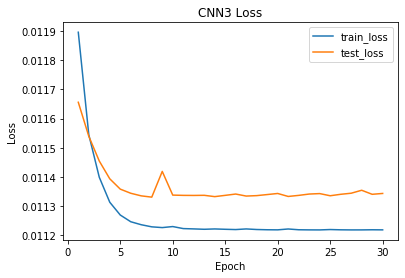

In [17]:
from matplotlib import pyplot as plt

epoch_np = np.arange(1,31,1)

plt.plot(epoch_np, train_loss_list)
plt.plot(epoch_np, test_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN3 Loss')
plt.legend(['train_loss', 'test_loss'])
plt.show()

# 이건 원래 

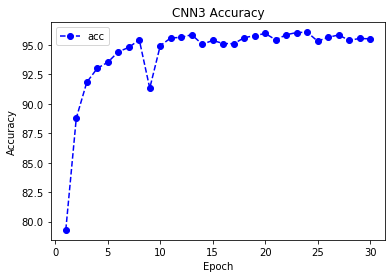

In [18]:
epoch_np = np.arange(1,31,1)

plt.plot(epoch_np, acc_list, 'rs--', marker="o", c = "b")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN3 Accuracy')
plt.legend(['acc'])
plt.show()

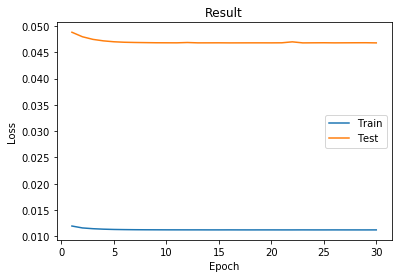

In [16]:
from matplotlib import pyplot as plt
import numpy as np
epoch_np = np.arange(1,31,1)

plt.plot(epoch_np, train_loss)
plt.plot(epoch_np, test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Result')
plt.legend(['Train', 'Test'])
plt.show()

# 이건 원래